In [97]:
import pandas as pd
import numpy as np

import multiprocessing
import gc

from time import time
import datetime

from tqdm import tqdm_notebook

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.feature_selection import RFECV

import lightgbm as lgb

sns.set()
%matplotlib inline

In [110]:
%%time

base_path = 'C:/Users/VenD/Downloads/ieee-fraud-detection/dataset/'

train_transaction = pd.read_csv(base_path + 'train_transaction.csv')
train_identity = pd.read_csv(base_path + 'train_identity.csv')

test_identity = pd.read_csv(base_path + 'test_identity.csv')
test_transaction = pd.read_csv(base_path + 'test_transaction.csv')

sample_submission = pd.read_csv(base_path + 'sample_submission.csv')

train = train_transaction.merge(train_identity, how='left', on='TransactionID')
test = test_transaction.merge(test_identity, how='left', on='TransactionID')

del train_transaction, train_identity, test_transaction, test_identity
gc.collect()

Wall time: 1min 9s


## Handle Missing Values and Feature Selection

We can eleminate some useless features already at the begining. Such as:

- Features with only 1 unique value
- Features with more than 90% missing values
- Features with the top value appears more than 90% of the time

In [8]:
def one_unique_value_features(df):
    one_value_cols = [col for col in df if df[col].nunique() == 1]
    
    return one_value_cols

In [9]:
def missing_value_features(df, threshold = 0.0):
    missing_value_cols = [col for col in df if (df[col].isnull().sum() / df.shape[0]) > threshold]
    
    return missing_value_cols

In [10]:
def frequent_value_features(df, threshold = 0.0):
    frequent_top_value_cols = [col for col in df if df[col].value_counts(dropna=False, normalize=True).values[0] > threshold]
    
    return frequent_top_value_cols

In [17]:
%%time

one_value_cols_train = one_unique_value_features(train)
one_value_cols_test = one_unique_value_features(test)

missing_value_cols_train = missing_value_features(train, threshold = 0.9)
missing_value_cols_test = missing_value_features(test, threshold = 0.9)

frequent_top_value_cols_train = frequent_value_features(train, threshold = 0.9)
frequent_top_value_cols_test = frequent_value_features(test, threshold = 0.9)

cols_to_drop = list(set(one_value_cols_train + one_value_cols_test + missing_value_cols_train +
                        missing_value_cols_test + frequent_top_value_cols_train +
                        frequent_top_value_cols_test))

# remove the target
cols_to_drop.remove('isFraud')

print("Total one value columns in train are: ", len(one_value_cols_train))
print("Total one value columns in test are: ", len(one_value_cols_test))

print("Total columns with more than 90% missing values in train are: ", len(missing_value_cols_train))
print("Total columns with more than 90% missing values in test are: ", len(missing_value_cols_test))

print("Total columns with more than 90% top value in train are: ", len(frequent_top_value_cols_train))
print("Total columns with more than 90% top value in test are: ", len(frequent_top_value_cols_test))

print(f"\nTotal {len(cols_to_drop)} features are going to be dropped for being useless\n")

Total one value columns in train are:  0
Total one value columns in test are:  1
Total columns with more than 90% missing values in train are:  12
Total columns with more than 90% missing values in test are:  10
Total columns with more than 90% top value in train are:  67
Total columns with more than 90% top value in test are:  79

Total 82 features are going to be dropped for being useless

Wall time: 22.2 s


In [19]:
# drop useless features from train and test set
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [111]:
# Function to reduce the DF size
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_memory_size_in_mega_bytes = df.memory_usage().sum() / 1024**2
    for col in tqdm_notebook(df.columns):
        col_data_type = df[col].dtypes
        if col_data_type in numerics:
            col_min = df[col].min()
            col_max = df[col].max()
            if str(col_data_type)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64) 
            else:
                if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif col_min > np.finfo(np.float64).min and col_max < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
                    
    reduced_df_memory_size_in_mega_bytes = df.memory_usage().sum() / 1024**2
    
    memory_diff = (df_memory_size_in_mega_bytes - reduced_df_memory_size_in_mega_bytes)
    reduce_percent =  (memory_diff / df_memory_size_in_mega_bytes) * 100
    
    if verbose:
        print('Memory usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)' \
              .format(df_memory_size_in_mega_bytes, reduced_df_memory_size_in_mega_bytes, reduce_percent))
        
    return df

In [23]:
# handle categorical features
for col in tqdm_notebook(train.columns):
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))

In [26]:
train = reduce_memory_usage(train)


Memory usage decreased from 1590.43 Mb to 426.33 Mb (73.2% reduction)


In [27]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']

del train
gc.collect()

110

In [28]:
# RFECV does not support NaNs
X.fillna(-999, inplace=True)

In [29]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [31]:
clf = lgb.LGBMClassifier(**params)
rfe = RFECV(estimator=clf, step=10, cv=KFold(n_splits=5, shuffle=False), scoring='roc_auc', verbose=2)

In [32]:
%%time

rfe.fit(X, y)

Fitting estimator with 349 features.
Fitting estimator with 339 features.
Fitting estimator with 329 features.
Fitting estimator with 319 features.
Fitting estimator with 309 features.
Fitting estimator with 299 features.
Fitting estimator with 289 features.
Fitting estimator with 279 features.
Fitting estimator with 269 features.
Fitting estimator with 259 features.
Fitting estimator with 249 features.
Fitting estimator with 239 features.
Fitting estimator with 229 features.
Fitting estimator with 219 features.
Fitting estimator with 209 features.
Fitting estimator with 199 features.
Fitting estimator with 189 features.
Fitting estimator with 179 features.
Fitting estimator with 169 features.
Fitting estimator with 159 features.
Fitting estimator with 149 features.
Fitting estimator with 139 features.
Fitting estimator with 129 features.
Fitting estimator with 119 features.
Fitting estimator with 109 features.
Fitting estimator with 99 features.
Fitting estimator with 89 features.
Fit

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
   estimator=LGBMClassifier(bagging_fraction=0.4181193142567742, bagging_seed=11,
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.3797454081646243, importance_type='split',
        learning_rate=0.006883242363721497, max_depth=-1, metric='auc',
        ...       silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0, verbosity=-1),
   min_features_to_select=1, n_jobs=None, scoring='roc_auc', step=10,
   verbose=2)

In [33]:
print('Optimal number of features:', rfe.n_features_)

Optimal number of features: 159


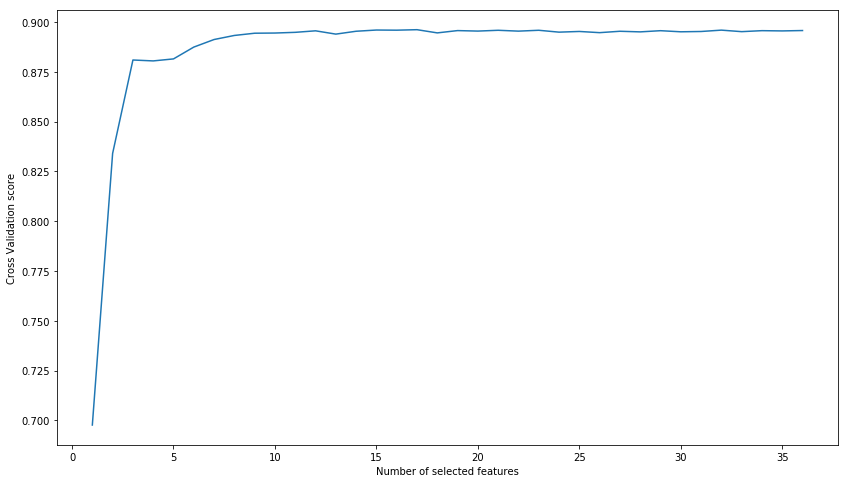

In [35]:
plt.figure(figsize=(14, 8))
plt.xlabel("Number of selected features")
plt.ylabel("Cross Validation score")
plt.plot(range(1, len(rfe.grid_scores_)+1), rfe.grid_scores_)
plt.show()

Printing out all features with rank 1

In [53]:
useful_features = []
for col in X.columns[rfe.ranking_ == 1]:
    useful_features.append(col)

If we do a feature selection using more `Folds` and small value of `step`, then `RFECV` will take more time and memory but it will select more (large no. of) useful features by doing more processing.

I selected `useful_features` from this link: https://www.kaggle.com/nroman/lgb-single-model-lb-0-9419

## Feature Selection From Train and Test Sets

In [65]:
useful_features = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
                   'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
                   'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3',
                   'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
                   'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
                   'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
                   'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
                   'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
                   'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
                   'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
                   'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
                   'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
                   'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
                   'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
                   'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
                   'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294', 'V303',
                   'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V322', 'V323', 'V324', 'V326',
                   'V329', 'V331', 'V332', 'V333', 'V335', 'V336', 'V338', 'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
                   'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33',
                   'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

In [66]:
useless_features = [col for col in train.columns if col not in useful_features]

useless_features.remove('isFraud')
useless_features.remove('TransactionDT')
useless_features.remove('TransactionID')

In [70]:
print(f'{len(useless_features)} Features are going to be dropped for being useless')

train = train.drop(useless_features, axis=1)
test = test.drop(useless_features, axis=1)

152 Features are going to be dropped for being useless


## Feature Engineering

In [72]:
# New feature - decimal part of the transaction amount
train['TransactionAmt_Decimal'] = ((train['TransactionAmt'] - train['TransactionAmt']
                                    .astype(int)) * 1000).astype(int)

test['TransactionAmt_Decimal'] = ((test['TransactionAmt'] - test['TransactionAmt']
                                    .astype(int)) * 1000).astype(int)

In [80]:
print(train.shape, test.shape)

(590540, 283) (506691, 282)


## Handle Categorical Features

In [112]:
for col in tqdm_notebook(train.columns):
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

Align the `train` and `test` datasets.

In [113]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

In [114]:
print(X.shape, test.shape)

(590540, 431) (506691, 431)


## Modelling

In [115]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [116]:
folds = TimeSeriesSplit(n_splits=5)

feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

aucs = []

training_start_time = time()
for fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on Fold {}'.format(fold + 1))
    
    # make train and validation set
    train_data = lgb.Dataset(X.iloc[train_idx], y.iloc[train_idx])
    valid_data = lgb.Dataset(X.iloc[valid_idx], y.iloc[valid_idx])
    
    clf = lgb.train(params, train_data, 10000, valid_sets=[train_data, valid_data],
                    verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
    
print('-' * 30)
print('Training has finished!')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC: ', np.mean(aucs))
print('-' * 30)

Training on Fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999943	valid_1's auc: 0.9026
Early stopping, best iteration is:
[846]	training's auc: 0.999803	valid_1's auc: 0.902797
Fold 1 finished in 0:02:37.723373
Training on Fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999673	valid_1's auc: 0.921731
Early stopping, best iteration is:
[823]	training's auc: 0.999124	valid_1's auc: 0.922159
Fold 2 finished in 0:04:56.327580
Training on Fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.998221	valid_1's auc: 0.914427
Early stopping, best iteration is:
[917]	training's auc: 0.997615	valid_1's auc: 0.914762
Fold 3 finished in 0:07:36.790770
Training on Fold 4
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.995621	valid_1's auc: 0.932892
Early stopping, best iteration is:
[1074]	training's auc: 0.996398	valid_1's a

## Feature Importances

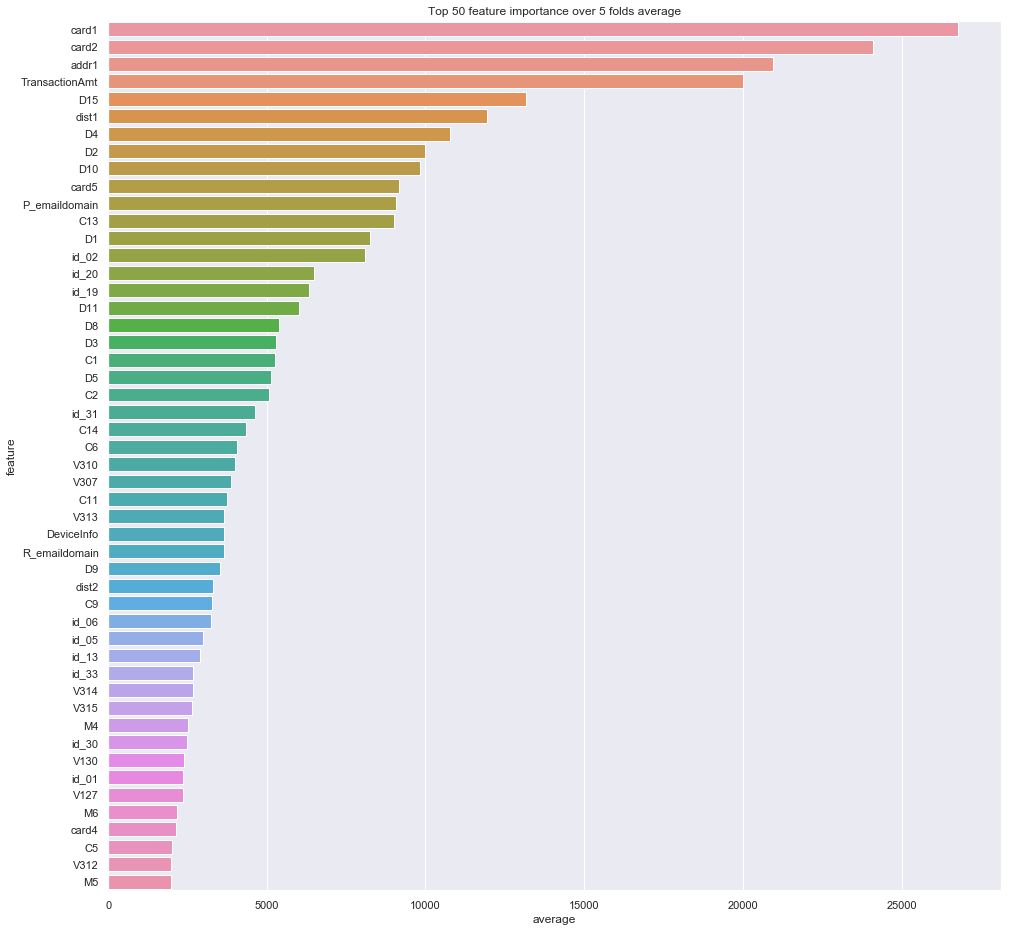

In [117]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold+1) 
                                                      for fold in range(folds.n_splits)]].mean(axis=1)

feature_importances.to_csv(base_path + 'feature_importances_1.csv')
plt.figure(figsize=(16, 16))
sorted_feature_importances = feature_importances.sort_values(by='average', ascending=False).head(50)
sns.barplot(x='average', y='feature', data=sorted_feature_importances)
plt.title('Top 50 feature importance over {} folds average'.format(folds.n_splits))
plt.show()

In [118]:
# clf now is trained with 80% of data and validated with 20%
best_iteration = clf.best_iteration

In [119]:
clf = lgb.LGBMClassifier(**params, num_boost_round=best_iteration)
clf.fit(X, y)

C:\Users\VenD\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(bagging_fraction=0.4181193142567742, bagging_seed=11,
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.3797454081646243, importance_type='split',
        learning_rate=0.006883242363721497, max_depth=-1, metric='auc',
        min_child_samples=20, min_child_weight=0.03454472573214212,
        min_data_in_leaf=106, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_boost_round=1186, num_leaves=491,
        objective='binary', random_state=47, reg_alpha=0.3899927210061127,
        reg_lambda=0.6485237330340494, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [120]:
test_predictions = clf.predict_proba(test)[:, 1]

In [121]:
sample_submission['isFraud'] = test_predictions

In [122]:
sample_submission.to_csv(base_path + 'submission_v2.csv', index=False)